<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/anomaly_detection_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install keras-layer-normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp36-none-any.whl size=5268 sha256=bc7bbe967ab1443e21c6aa968a7fe13a7c9dcd27f68c5284d02af93ef5d49bbe
  Stored in directory: /root/.cache/pip/wheels/54/80/22/a638a7d406fd155e507aa33d703e3fa2612b9eb7bb4f4fe667
Successfully built keras-layer-normalization


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

from os.path import join
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization
from keras.layers import Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K

import matplotlib.pyplot as plt
import argparse
import numpy as np
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
import math
class Config:
    def __init__(self, data_dir, single_test_case, model_path, retrain=0):
        self.DATASET_PATH = join(data_dir,"UCSDped1/Train")
        self.TEST_DIR = join(data_dir,"UCSDped1/Test/")
        self.SINGLE_TEST_PATH = join(self.TEST_DIR, single_test_case)
        self.BATCH_SIZE = 4
        self.EPOCHS = 5
        self.MODEL_PATH = join(model_path,"model.hdf5")
        self.retrain = retrain
        self.latent_dim = 100


def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_training_set(conf):
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.DATASET_PATH)):
        directory_path = join(conf.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))

                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips


def get_model(conf):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if conf.retrain == 1 and os.path.isfile(conf.MODEL_PATH):
        vae=load_model(path, custom_objects={'LayerNormalization': LayerNormalization})
        return vae
    input_train = get_training_set(conf)
    input_train = np.array(input_train)

    validation_split = 0.2
    verbosity = 1

    # # =================
    # # Encoder
    # # =================
    
    # Definition
    i       = Input(shape=(10, 256, 256, 1), name='encoder_input')

    seq.add()
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))

    cx      = TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same", activation='relu'))(i)
    cx      = LayerNormalization()(cx)
    cx      = TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same", activation='relu'))(cx)
    cx      = LayerNormalization()(cx)
    cx      = ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True)(cx)
    cx      = LayerNormalization()(cx)
    cx      = ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True)(cx)
    x       = Flatten()(cx)
    x       = Dense(1024, activation='relu')(x)
    x       = BatchNormalization()(x)
    mu      = Dense(conf.latent_dim, name='latent_mu')(x)
    sigma   = Dense(conf.latent_dim, name='latent_sigma')(x)
    
    # Get Conv2D shape for Conv2DTranspose operation in decoder
    conv_shape = K.int_shape(cx)
    
    # Define sampling with reparameterization trick
    def sample_z(args):
      mu, sigma = args
      batch     = K.shape(mu)[0]
      dim       = K.int_shape(mu)[1]
      eps       = K.random_normal(shape=(batch, dim))
      return mu + K.exp(sigma / 2) * eps
    
    # Use reparameterization trick to ....??
    z       = Lambda(sample_z, output_shape=(conf.latent_dim, ), name='z')([mu, sigma])
    
    # Instantiate encoder
    encoder = Model(i, [mu, sigma, z], name='encoder')
    encoder.summary()
    
    # =================
    # Decoder
    # =================
    
    # Definition
    d_i   = Input(shape=(conf.latent_dim, ), name='decoder_input')
    x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3]* conv_shape[4], activation='relu')(d_i)
    x     = BatchNormalization()(x)
    x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3], conv_shape[4]))(x)
    cx    = ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True)(x)
    cx    = LayerNormalization()(cx)
    cx    = ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True)(cx)
    cx    = LayerNormalization()(cx)
    cx    = TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same"))(cx)
    cx    = LayerNormalization()(cx)
    cx    = TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same"))(cx)
    o     = TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same"), name='decoder_output')(cx)

    # Instantiate decoder
    decoder = Model(d_i, o, name='decoder')
    decoder.summary()
    
    # =================
    # VAE as a whole
    # =================
    
    # Instantiate VAE
    vae_outputs = decoder(encoder(i)[2])
    vae         = Model(i, vae_outputs, name='vae')
    vae.summary()
    
    # Define loss
    def kl_reconstruction_loss(true, pred):
      # Reconstruction loss
      reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * 10 * 256 * 256
      # KL divergence loss
      kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      # Total loss = 50% rec + 50% KL divergence loss
      return K.mean(reconstruction_loss + kl_loss)
    
    print(vae.summary())
    # Compile VAE
    vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
    !mkdir training_1
    checkpoint_path = "training_1/cp.ckpt"
    checkpoint_dir = dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

    # Train autoencoder
    vae.fit(input_train, input_train, epochs = conf.EPOCHS, batch_size = conf.BATCH_SIZE, validation_split = validation_split, shuffle=False, callbacks=[cp_callback])
    
    vae.save(conf.MODEL_PATH,save_format='h5')
    return vae



def TEST_get_training_set(conf):
    print("Starting")
    clips =  get_training_set(conf)
    print("Total clips: %d" % len(clips))
    for clip in clips:
        print("Sequence size: %d" % len(clip))
        for image in clip:
            plt.imshow(np.uint8(image))
            plt.show()



def get_single_test(conf):

    sz = 0
    for f in sorted(listdir(conf.SINGLE_TEST_PATH)):
        if str(join(conf.SINGLE_TEST_PATH, f))[-3:] == "tif":
          sz = sz +1
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(conf.SINGLE_TEST_PATH)):
        if str(join(conf.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(conf.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test



def evaluate(conf):
    model = get_model(conf, True)
    print("got model")
    test = get_single_test(conf)
    print("got test")
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    #for j in range(0, sz):
    #    clip_10 = reconstructed_sequences[j]
    #    img_prev = np.reshape(clip_10[0],(256,256))*256
    #    for k in range(1,2):
    #        img = np.reshape(clip_10[k],(256,256))*256
            #optical_flow(img, img_prev)

    #        img_prev = img
            #print(img)
            #print("end of array\n")
            #cv2_imshow(img)
            #v2.waitKey(0)

    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()
    #sr = sigmoid(sr)
    # plot the regularity scores
    #plt.plot(sr)
    #plt.ylabel('regularity score Sr(t)')
    #plt.xlabel('frame t')
    #plt.show()




/content
got model
got test


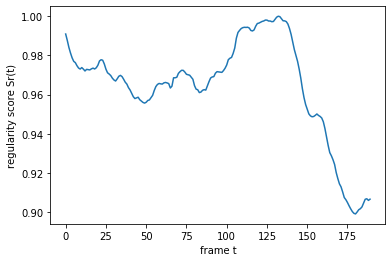

In [0]:


# Instantiate the parser
#parser = argparse.ArgumentParser(description='Vidasa Extended -- Anomaly Detection System')


#parser.add_argument('--data',type=str,
 #                   help='Data directory path')

#args = parser.parse_args()
model_path = "/content/drive/My Drive/VAE/"
os.makedirs(model_path, exist_ok=True)
conf = Config(data_dir="/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/", single_test_case="Test022", mode_path=model_path, retrain=1)

evaluate(conf)
#TEST_get_training_set(conf)


